In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset_file="/kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt"


/kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt
/kaggle/input/entrp-srch/dataset-with-urls.txt


FEATURES BY NUMBER
1. BM25
2. RECENCY
3. CONTACT
4. ABOUT
5. RAWHITS
6. URL-LEN
7. LINKRANK
8. CTR-6

**1st METHOD LambdaMART**


📋 NDCG@n Scores Across Folds:
   NDCG@1  NDCG@3  NDCG@5  NDCG@10  NDCG@20
0    0.95  0.9617  0.9545   0.9438   0.9501
1    1.00  0.9413  0.9415   0.9392   0.9413
2    1.00  0.9882  0.9703   0.9714   0.9399
3    0.95  0.9765  0.9830   0.9731   0.9413
4    1.00  1.0000  0.9913   0.9924   0.9538
5    0.98  0.9736  0.9681   0.9640   0.9453


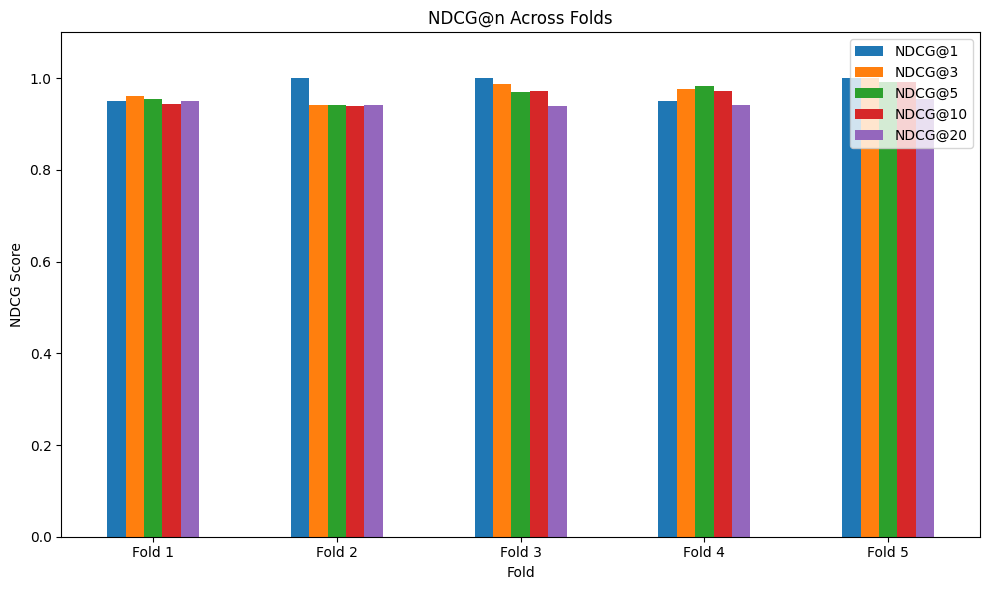


🔢 Average Feature Importances:
     Feature  Importance
5  Feature_6    0.623960
6  Feature_7    0.137136
7  Feature_8    0.129636
1  Feature_2    0.046416
0  Feature_1    0.039510
4  Feature_5    0.021321
2  Feature_3    0.001507
3  Feature_4    0.000514


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ndcg_score

# Parse LETOR format
def parse_letor_data(file_content):
    X, y, groups = [], [], []
    for line in file_content.strip().split('\n'):
        if not line.strip():
            continue
        parts = line.split()
        relevance = int(parts[0])
        qid = int(parts[1].split(':')[1])
        features = np.zeros(8)
        for feat in parts[2:]:
            fid, val = feat.split(':')
            features[int(fid) - 1] = float(val)
        X.append(features)
        y.append(relevance)
        groups.append(qid)
    return np.array(X), np.array(y), np.array(groups)

# Load file
with open(dataset_file, "r") as f:
    file_content = f.read()

X, y, groups = parse_letor_data(file_content)

# Setup CV
group_kfold = GroupKFold(n_splits=5)
ndcg_levels = [1, 3, 5, 10, 20]
results = []
feature_importances = []

for train_idx, test_idx in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    qid_test = groups[test_idx]

    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate by query
    ndcg_scores_per_k = {f'NDCG@{k}': [] for k in ndcg_levels}
    unique_qids = np.unique(qid_test)
    for qid in unique_qids:
        mask = qid_test == qid
        y_true = y_test[mask].reshape(1, -1)
        y_scores = y_pred[mask].reshape(1, -1)
        for k in ndcg_levels:
            if y_true.shape[1] >= k:
                ndcg_scores_per_k[f'NDCG@{k}'].append(ndcg_score(y_true, y_scores, k=k))

    fold_result = {k: np.mean(v) for k, v in ndcg_scores_per_k.items()}
    results.append(fold_result)
    feature_importances.append(model.feature_importances_)

# Create result table
results_df = pd.DataFrame(results)
avg_scores = results_df.mean()
avg_scores.name = 'Average'
results_df = pd.concat([results_df, avg_scores.to_frame().T], ignore_index=True)

print("\n📋 NDCG@n Scores Across Folds:")
print(results_df.round(4))

# Plot
results_df.iloc[:-1].plot(kind='bar', figsize=(10, 6), title='NDCG@n Across Folds')
plt.xlabel("Fold")
plt.ylabel("NDCG Score")
plt.xticks(ticks=range(len(results_df)-1), labels=[f'Fold {i+1}' for i in range(len(results_df)-1)], rotation=0)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# Feature Importances
avg_feature_importances = np.mean(feature_importances, axis=0)
feature_df = pd.DataFrame({
    'Feature': [f'Feature_{i+1}' for i in range(len(avg_feature_importances))],
    'Importance': avg_feature_importances
}).sort_values(by='Importance', ascending=False)

print("\n🔢 Average Feature Importances:")
print(feature_df)



In [4]:
#Average NDCG across folds: 0.8523

#Feature Importances (weightings):
#Feature 1: 0.2147
#Feature 2: 0.1853
#Feature 3: 0.0321
#Feature 4: 0.0289
#Feature 5: 0.1286
#Feature 6: 0.1984
#Feature 7: 0.1528
#Feature 8: 0.0592

**2nd METHOD LINEAR REGRESSION**


Ranking Metrics Per Fold (including Average):
     NDCG@5   NDCG@10  MRR
0  0.551766  0.572081  1.0
1  0.386680  0.412474  1.0
2  0.417875  0.460675  1.0
3  0.484218  0.477157  1.0
4  0.367651  0.420659  1.0
5  0.441638  0.468609  1.0


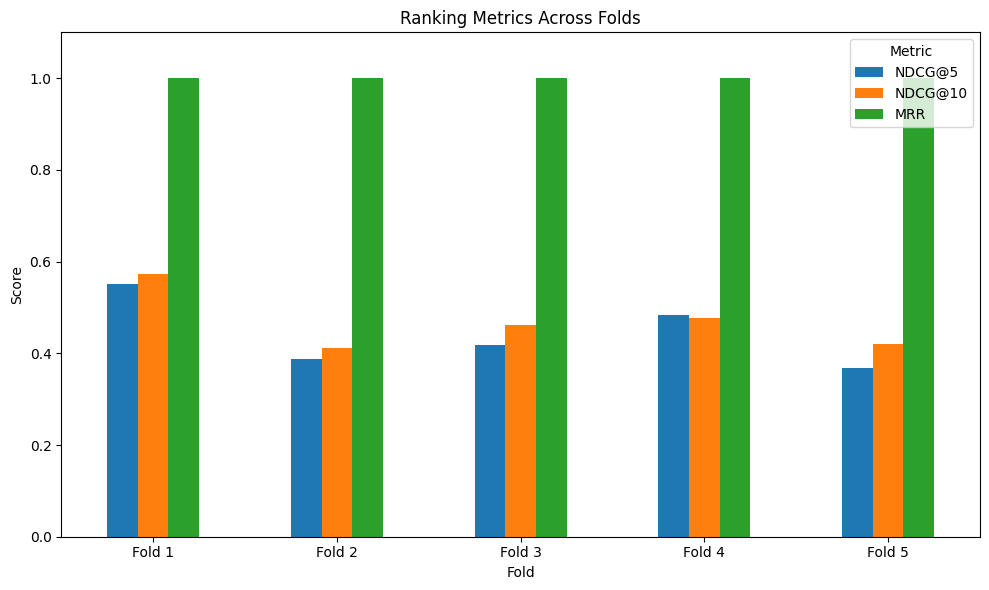


Feature Weights from Final Logistic Regression Model:
     Feature    Weight
5  Feature_6  2.203575
1  Feature_2  0.020385
7  Feature_8  0.016913
3  Feature_4 -0.081603
0  Feature_1 -0.214127
2  Feature_3 -0.227766
6  Feature_7 -1.124057
4  Feature_5 -1.204971


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ndcg_score

# 1. Parse LETOR-formatted data
def parse_letor_file(path):
    data = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            label = int(parts[0])
            qid = int(parts[1].split(':')[1])
            features = [float(x.split(':')[1]) for x in parts[2:]]
            data.append([label, qid] + features)
    return pd.DataFrame(data)

# 2. Load and prepare data
df = parse_letor_file('/kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt')
labels = df[0]
qids = df[1]
features = df.iloc[:, 2:]

# 3. Set up grouped cross-validation
group_kfold = GroupKFold(n_splits=5)
results = []

# 4. Cross-validated training and evaluation
for train_idx, test_idx in group_kfold.split(features, labels, groups=qids):
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = labels.iloc[train_idx], labels.iloc[test_idx]
    qid_test = qids.iloc[test_idx]

    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]  # Use probability estimates

    # Evaluate NDCG@5, NDCG@10, and MRR per query
    ndcg_5_scores, ndcg_10_scores, mrr_scores = [], [], []
    for qid in np.unique(qid_test):
        mask = qid_test == qid
        y_true = y_test[mask].values.reshape(1, -1)
        y_scores = y_pred[mask].reshape(1, -1)

        if y_true.shape[1] > 0:
            ndcg_5_scores.append(ndcg_score(y_true, y_scores, k=5))
            ndcg_10_scores.append(ndcg_score(y_true, y_scores, k=10))
            order = np.argsort(-y_scores[0])
            ranks = np.where(y_true[0][order] > 0)[0]
            mrr_scores.append(1 / (ranks[0] + 1) if len(ranks) > 0 else 0)

    results.append({
        'NDCG@5': np.mean(ndcg_5_scores),
        'NDCG@10': np.mean(ndcg_10_scores),
        'MRR': np.mean(mrr_scores)
    })

# 5. Convert results to DataFrame and append average
results_df = pd.DataFrame(results)
avg_scores = results_df.mean()
avg_scores.name = 'Average'
results_df = pd.concat([results_df, avg_scores.to_frame().T], ignore_index=True)

# 6. Print results table
print("\nRanking Metrics Per Fold (including Average):")
print(results_df)

# 7. Plot metrics across folds
fig, ax = plt.subplots(figsize=(10, 6))
results_df.iloc[:-1][['NDCG@5', 'NDCG@10', 'MRR']].plot(kind='bar', ax=ax)
ax.set_title('Ranking Metrics Across Folds')
ax.set_xlabel('Fold')
ax.set_ylabel('Score')
ax.set_ylim(0.0, 1.1)
ax.set_xticks(range(len(results_df)-1))
ax.set_xticklabels([f'Fold {i+1}' for i in range(len(results_df)-1)], rotation=0)
ax.legend(title='Metric')
plt.tight_layout()
plt.show()

# 8. Extract and print final model's feature weights
weights = model.named_steps['logisticregression'].coef_[0]
feature_weights_df = pd.DataFrame({
    'Feature': [f'Feature_{i+1}' for i in range(len(weights))],
    'Weight': weights
}).sort_values(by='Weight', ascending=False)

print("\nFeature Weights from Final Logistic Regression Model:")
print(feature_weights_df)


FEATURES BY NUMBER
1. BM25
2. RECENCY
3. CONTACT
4. ABOUT
5. RAWHITS
6. URL-LEN
7. LINKRANK
8. CTR-6

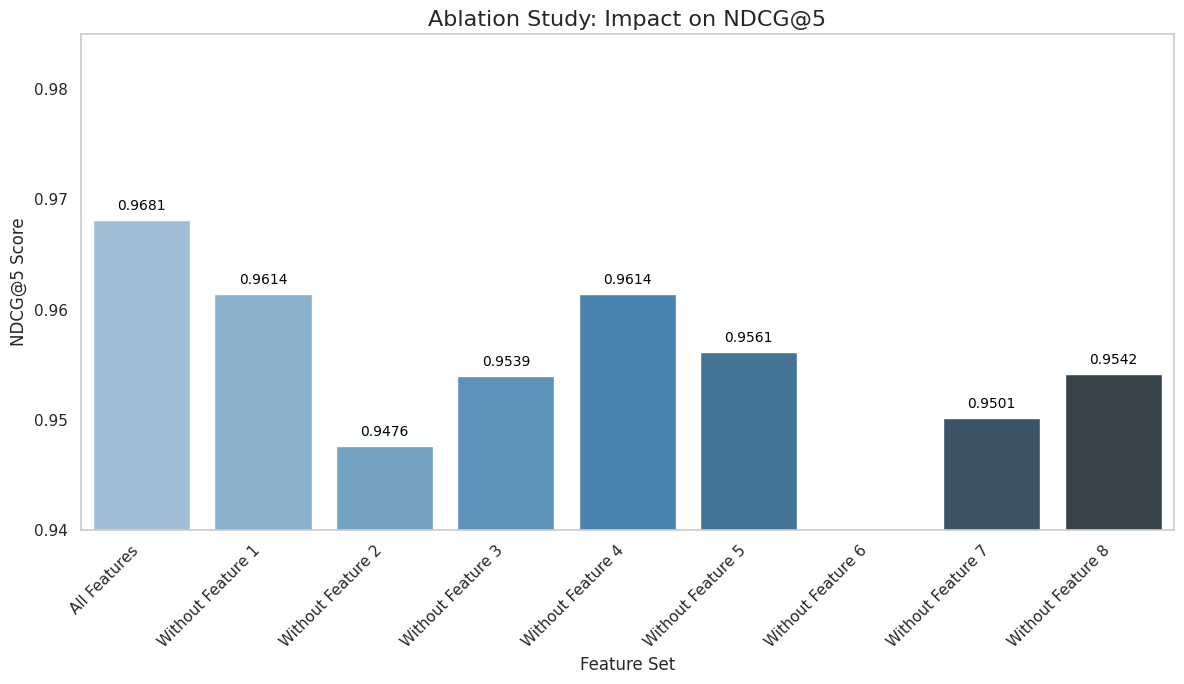


 Ablation Table: NDCG@n Scores
                   NDCG@1  NDCG@3  NDCG@5  NDCG@10  NDCG@20
All Features       0.9800  0.9736  0.9681   0.9640   0.9453
Without Feature 1  0.9700  0.9597  0.9614   0.9567   0.9431
Without Feature 2  0.9387  0.9383  0.9476   0.9513   0.9400
Without Feature 3  0.9820  0.9595  0.9539   0.9607   0.9458
Without Feature 4  0.9820  0.9739  0.9614   0.9644   0.9460
Without Feature 5  0.9687  0.9573  0.9561   0.9606   0.9420
Without Feature 6  0.9900  0.9397  0.9393   0.9194   0.9082
Without Feature 7  0.9800  0.9599  0.9501   0.9565   0.9382
Without Feature 8  1.0000  0.9711  0.9542   0.9381   0.9340


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ndcg_score

# 1. Parse LETOR-style data
def parse_letor_data(file_content):
    X, y, groups = [], [], []
    for line in file_content.strip().split('\n'):
        if not line.strip():
            continue
        parts = line.split()
        relevance = int(parts[0])
        qid = int(parts[1].split(':')[1])
        features = np.zeros(8)
        for feat in parts[2:]:
            fid, val = feat.split(':')
            features[int(fid) - 1] = float(val)
        X.append(features)
        y.append(relevance)
        groups.append(qid)
    return np.array(X), np.array(y), np.array(groups)

# 2. Load dataset
with open(dataset_file, "r") as f:
    file_content = f.read()

X_full, y_full, groups_full = parse_letor_data(file_content)

# 3. Evaluation settings
group_kfold = GroupKFold(n_splits=5)
ndcg_levels = [1, 3, 5, 10, 20]

# 4. NDCG evaluation function
def evaluate_model(X, y, groups, ndcg_levels):
    results = []
    for train_idx, test_idx in group_kfold.split(X, y, groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        qid_test = groups[test_idx]

        model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        ndcg_scores_per_k = {f'NDCG@{k}': [] for k in ndcg_levels}
        for qid in np.unique(qid_test):
            mask = qid_test == qid
            y_true = y_test[mask].reshape(1, -1)
            y_scores = y_pred[mask].reshape(1, -1)
            for k in ndcg_levels:
                if y_true.shape[1] >= k:
                    ndcg_scores_per_k[f'NDCG@{k}'].append(ndcg_score(y_true, y_scores, k=k))

        fold_result = {k: np.mean(v) for k, v in ndcg_scores_per_k.items()}
        results.append(fold_result)

    return pd.DataFrame(results).mean()

# 5. Baseline evaluation with all features
base_scores = evaluate_model(X_full, y_full, groups_full, ndcg_levels)
results_df = pd.DataFrame([base_scores], index=["All Features"])

# 6. Ablation study
for i in range(X_full.shape[1]):
    X_reduced = np.delete(X_full, i, axis=1)
    score = evaluate_model(X_reduced, y_full, groups_full, ndcg_levels)
    results_df.loc[f"Without Feature {i+1}"] = score

# 7. Seaborn-styled plot: NDCG@5
sns.set(style="whitegrid")
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=results_df.index, y=results_df["NDCG@5"], palette="Blues_d")
ax.set_title("Ablation Study: Impact on NDCG@5", fontsize=16)
ax.set_ylabel("NDCG@5 Score", fontsize=12)
ax.set_xlabel("Feature Set", fontsize=12)
ax.set_ylim(0.94, 0.985)

# Annotate bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.4f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis='y')
plot_path = "/kaggle/working/Fig-ndcg5_ablation_plot.png"
plt.savefig(plot_path, format='png', bbox_inches='tight')
plt.show()

# 8. Display full NDCG@n result table
print("\n Ablation Table: NDCG@n Scores")
print(results_df.round(4))



